### 참고 : Collaborative Filtering for Implicit Feedback Datasets - Yifan Hu

http://yifanhu.net/PUB/cf.pdf

In [1]:
import pandas as pd
import numpy as np
import os.path
import csv
import operator

In [2]:
# 영화 300개 자료 저장
# User 수는 1000명
data = {}
movie_id = 0
user_name = 0
rating = 0
user_list = []


with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            continue
        line_split = line.split(',')
        user_name = int(line_split[0])
        if user_name in user_list:
            continue
        else:
            user_list.append(user_name)
        if len(user_list) > 1000:
            break

with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            movie_id = int(line.replace(":","")) - 1
            if(movie_id >= 300): break
            data[movie_id] = {}
        else:
            line_split = line.split(',')
            user_name = int(line_split[0])
            rating = int(line_split[1])
            if user_name in user_list:
                data[movie_id][user_name] = rating

#### Explicit Feedback data X

In [3]:
Matrix = np.nan_to_num(np.array(pd.DataFrame(data)))

Matrix

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 1., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 3., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.]])

### 선호도 행렬 P

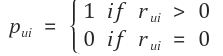

In [4]:
# Raiting 값이 존재하면 1 / 존재하지 않으면 0으로 초기화
P = np.copy(Matrix)
P[P > 0] = 1
print(P)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


### 신뢰도 행렬 C

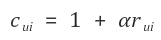

In [5]:
# alpha = 40 으로 초기화(위 논문에서 좋은 결과가 나온 값)
C = 1 + 40 * Matrix
print(C)
print()

[[201.   1.   1. ...   1.   1.   1.]
 [  1.   1. 161. ...   1.  41.   1.]
 [121.   1.   1. ...   1.   1.   1.]
 ...
 [  1.   1. 121. ...   1.   1.   1.]
 [161.   1.   1. ...   1.   1.   1.]
 [  1. 121.   1. ...   1.   1.   1.]]



### Loss Function

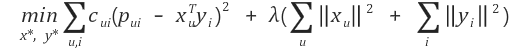

In [6]:
def loss_function(C, P, xTy, lambda_, X, Y):
    predict_error = np.sum(C * np.square(P - xTy))
    return predict_error, predict_error + lambda_ * (np.sum(np.square(X)) + np.sum(np.square(Y)))

#### Optimize user factors



#### Optimize item factors



In [7]:
def optimize(X, Y, C, P, num_of_user, num_of_item, dimension, lambda_):
    # user
    yT = np.transpose(Y)
    D = np.dot(lambda_, np.identity(dimension)) # lambda * identity_matirix
    for u in range(num_of_user):
        yT_Cu_y_D_inverse = np.linalg.inv(np.dot(np.dot(yT, np.diag(C[u])), Y) + D) # (yTCuY + D)의 역행렬
        yT_Cu_pu = np.dot(np.dot(yT, np.diag(C[u])), P[u])
        X[u] = np.dot(yT_Cu_y_D_inverse, yT_Cu_pu)
    
    # item
    xT = np.transpose(X)
    for i in range(num_of_item):
        xT_Ci_x_D_inverse = np.linalg.inv(np.dot(np.dot(xT, np.diag(C[:, i])), X) + D) # (xT_Ci_x + D)의 역행렬
        xT_Ci_pi = np.dot(np.dot(xT, np.diag(C[:, i])), P[:, i])
        Y[i] = np.dot(xT_Ci_x_D_inverse, xT_Ci_pi)

In [11]:
# 각 파라미터별 total_loss
result = []

# 정규화에 필요한 lambda
lambda_ = [i for i in range(10,30,10)]

# Latent Factor 행렬의 차원
dimension = [i for i in range(10,410,40)]

# Latent Factor 행렬의 차원
alpha_ = [i for i in range(10,50,10)]

# user, item 수 
num_of_user, num_of_item = Matrix.shape[0], Matrix.shape[1]

for a in alpha_:
    for d in dimension:
        for l in lambda_:
            # Latent Factor Matrix 초기 랜덤값 생성
            # X : 유저
            # Y : 영화
            np.random.seed(100)
            X = np.random.rand(num_of_user, d) * 0.01
            Y = np.random.rand(num_of_item, d) * 0.01

            C = 1 + a * Matrix
            temp_losses = 10000000
            temp_predict_error = 10000000

            print('lambda : %d, dimension : %d alpha : %d' %(l,d,a))
            print()
            i = 0
            while(True):
                i += 1
                print('---step %d---' % i)
                if i!=0:    
                    optimize(X, Y, C, P, num_of_user, num_of_item, d, l)
                    predict = np.dot(X, np.transpose(Y))
                    predict_error, total_loss = loss_function(C, P, predict,l,X,Y)

                    if temp_predict_error < predict_error:
                        break                
                    if temp_losses - total_loss < 1000 or i == 10:
                        break

                temp_predict_error = predict_error
                temp_losses = total_loss

            print("total loss: %f" % total_loss)
            print("predict_error: %f" % predict_error)
            print()
            print()

            result.append([d,l,a,predict_error])

lambda : 10, dimension : 10 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
---step 7---
---step 8---
---step 9---
---step 10---
total loss: 52135.558131
predict_error: 38799.372578


lambda : 20, dimension : 10 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
---step 7---
---step 8---
total loss: 60025.177800
predict_error: 39758.280471


lambda : 10, dimension : 50 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
total loss: 29796.383037
predict_error: 10591.767195


lambda : 20, dimension : 50 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
---step 7---
total loss: 43524.086629
predict_error: 12875.169004


lambda : 10, dimension : 90 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 25357.717392
predict_error: 4732.664474


lambda : 20, dimension : 90 alpha : 10

---step 1---
---s

---step 2---
---step 3---
---step 4---
---step 5---
total loss: 42933.725252
predict_error: 5702.411120


lambda : 10, dimension : 210 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 26108.937830
predict_error: 2689.853526


lambda : 20, dimension : 210 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 42846.806920
predict_error: 5654.724959


lambda : 10, dimension : 250 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 26797.912786
predict_error: 2677.047250


lambda : 20, dimension : 250 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 43019.391230
predict_error: 5609.818838


lambda : 10, dimension : 290 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 27498.060404
predict_error: 2689.185916


lambda : 20, dimension : 290 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 43687.668680
pr

In [14]:
pd.DataFrame(result).sort_values(by = [3])

0   1   2             3
38  370  10  20   2629.295689
36  330  10  20   2632.531531
56  330  10  30   2645.298668
58  370  10  30   2673.798834
52  250  10  30   2677.047250
34  290  10  20   2679.003750
54  290  10  30   2689.185916
50  210  10  30   2689.853526
32  250  10  20   2697.062539
72  250  10  40   2702.773742
70  210  10  40   2708.051022
30  210  10  20   2721.485529
76  330  10  40   2735.923469
74  290  10  40   2742.949253
78  370  10  40   2771.982261
18  370  10  10   2782.083810
16  330  10  10   2795.034611
14  290  10  10   2806.439249
48  170  10  30   2810.096282
68  170  10  40   2818.928899
12  250  10  10   2824.157611
28  170  10  20   2824.193744
10  210  10  10   2853.844995
8   170  10  10   2922.842906
6   130  10  10   3123.766140
66  130  10  40   3130.261261
26  130  10  20   3252.973859
46  130  10  30   3331.989395
4    90  10  10   4732.664474
24   90  10  20   4821.840262
..  ...  ..  ..           ...
47  130  20  30   5938.220838
29  170  20  20   5941.438407
27  130  20  20   6114.121015
19  370  20  10   6837.740264
17  330  20  10   6940.386198
45   90  20  30   6964.525212
15  290  20  10   6979.927249
65   90  20  40   6984.020840
13  250  20  10   7016.705931
25   90  20  20   7101.962525
11  210  20  10   7112.203665
9   170  20  10   7178.566355
7   130  20  10   7326.472457
5    90  20  10   8016.520529
2    50  10  10  10591.767195
22   50  10  20  11304.967045
42   50  10  30  11966.985011
62   50  10  40  12630.375312
23   50  20  20  12679.384965
3    50  20  10  12875.169004
43   50  20  30  12960.818833
63   50  20  40  13467.552335
0    10  10  10  38799.372578
1    10  20  10  39758.280471
20   10  10  20  46428.991479
21   10  20  20  47437.035841
40   10  10  30  50529.364800
41   10  20  30  51739.972693
60   10  10  40  53327.980468
61   10  20  40  54465.971449

[80 rows x 4 columns]

- 가장 이상적인 초기값
    - dimension = 370
    - lambda_ = 10
    - alpha = 20

### 최종 모델

In [15]:
# 정규화에 필요한 lambda
lambda_ = 10

# Latent Factor 행렬의 차원
dimension = 370

alpha = 20

# user, item 수 
num_of_user, num_of_item = Matrix.shape[0], Matrix.shape[1]

# Latent Factor Matrix 초기 랜덤값 생성
# X : 유저
# Y : 영화
np.random.seed(100)
X = np.random.rand(num_of_user, d) * 0.01
Y = np.random.rand(num_of_item, d) * 0.01

C = 1 + alpha * Matrix
temp_losses = 10000000
temp_predict_error = 10000000

print('lambda : %d, dimension : %d' %(l,d))
print()
i = 0
while(True):
    i += 1
    print('---step %d---' % i)
    if i!=0:    
        optimize(X, Y, C, P, num_of_user, num_of_item, d, l)
        predict = np.dot(X, np.transpose(Y))
        predict_error, total_loss = loss_function(C, P, predict,l,X,Y)

        if temp_predict_error < predict_error:
            break                
        if temp_losses - total_loss < 1000 or i == 10:
            break

    temp_predict_error = predict_error
    temp_losses = total_loss

print("total loss: %f" % total_loss)
print("predict_error: %f" % predict_error)
print()
print()

result_matrix = np.dot(X, np.transpose(Y))

lambda : 20, dimension : 370

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 42206.373756
predict_error: 5844.219900




In [16]:
result_matrix

array([[ 0.98634405, -0.13158723, -0.11921972, ...,  0.06416346,
         0.13612756, -0.01116031],
       [ 0.58100977,  0.16981198,  0.99403672, ...,  0.20149689,
         1.00151224,  0.02854591],
       [ 0.99094368,  0.14467849,  0.02114363, ...,  0.05546217,
         0.18029056,  0.00808861],
       ...,
       [ 0.09246973,  0.1532611 ,  0.98209636, ..., -0.00353585,
         0.54894716, -0.0110194 ],
       [ 0.99158125,  0.20247106,  0.25385307, ...,  0.02405924,
         0.37860486, -0.05152268],
       [ 0.20516819,  0.95516217,  0.1336867 , ...,  0.0425397 ,
         0.28857319,  0.00856342]])